# Brian2 simulation of a temporal n-bit parity task

The task is to find out if the sum of 1s is even or odd (the parity) in a
temporal stream of bits.

Bits are send in one after the other with a fixed input delay.
The neuron is stimulated if there is a 1 in the stream.

The neuron's membrane potential is read out after all bits are streamed in
after waiting for an additional readout delay.

Quantities are defined without units first, but units are attached
when entering Brian2. Think of times in ms.

Implementation partially based on: https://github.com/IGITUGraz/LSM

Sebastian Schmitt, 2021

In [16]:
from collections import defaultdict

from brian2 import ms, run, defaultclock
from brian2 import NeuronGroup, Synapses, SpikeGeneratorGroup, StateMonitor

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_n_bit_parity_spike_times(n_bit, stim_times, input_delay_per_bit):
    """Generates spike times for the n-bit parity task

    n_bit: number of bits
    stim_times: times at which a stimulus starts
    input_delay_per_bit: input delay for each each bit
    the first bit is not delayed,
    the second bit is delayed by delay_per_bit
    the third bit is delayed by 2*delay_per_bit

    returns one spike train for each bit, the states for each bit and the target parity
    """

    # 2 is for binary states
    raw_bit_states = np.random.randint(2, size=(n_bit, np.size(stim_times)))

    # filter out all 0 states, only 1 states generate spikes
    # dot product with stimulus times at every non masked state
    timed_bit_states = np.array([times.compressed() for times in
                                 np.ma.masked_values(raw_bit_states, 0) * stim_times],
                                dtype=object)

    timed_bit_states += np.arange(len(timed_bit_states))*input_delay_per_bit

    target_parities = np.sum(raw_bit_states, 0) % 2

    return raw_bit_states, timed_bit_states, target_parities

In [3]:
def flatten(timed_bit_states):
    """Brian2 needs the flat list of spike times and the associated neuron indices
    """

    indices = np.concatenate([[i]*len(entry)
                              for i, entry in enumerate(timed_bit_states)])
    spike_times = np.concatenate(timed_bit_states)

    return indices, spike_times

In [4]:
def simulation(sim_time, n_bit, membrane_time_constant, refractory_period, indices, spike_times):
    """Run the simulation

    sim_time: simulation time
    n_bit: number of bits for the parity task
    indices: indices corresponding to spike times
    spike_times: stimulus spike times
    """

    n_neurons = 1

    neuron_eqs = """dx/dt = -x/tau : 1 (unless refractory)"""

    parameters = {
        "tau": membrane_time_constant*ms,
        "v_thresh": 1,
        "v_reset": 0
    }

    neurons = NeuronGroup(n_neurons, neuron_eqs,
                          threshold='x>v_thresh',
                          reset='x = v_reset',
                          namespace=parameters,
                          method='euler',
                          refractory=refractory_period*ms)
    neurons.x = 0

    defaultclock.dt = 0.01*ms

    stimulus = SpikeGeneratorGroup(n_bit, indices, spike_times*ms)

    synapses = Synapses(stimulus, neurons, 'w : 1', on_pre='x_post += w')
    synapses.connect()
    synapses.w = 0.75

    neuron_monitor = StateMonitor(neurons, ['x'], record=True)

    run(sim_time*ms)

    return neuron_monitor

In [5]:
def eval_predictions(predictions, target_parities, raw_bit_states, label):
    """Evaluate predictions
    predictions: predictions of the analysis
    target_parities: target parities
    raw_bit_states: raw bit states
    label: dataset label, e.g., train or test
    """

    fails = defaultdict(int)

    n_fails = sum(abs(predictions - target_parities))
    n_total = len(target_parities)
    print("mismatched {} examples: {:d}/{:d} [{:.1f}%]".format(
        label, n_fails, n_total,
        float(n_fails) / n_total * 100))

    sum_of_bits = np.sum(raw_bit_states, 0)

    for sob, prediction, target in zip(sum_of_bits, predictions, target_parities):
        if prediction != target:
            fails[sob] += 1

    for sob, count in fails.items():
        print(f"{sob}: {count} times wrongly classified")

    return float(n_fails) / n_total

In [10]:
def analysis(states, target_parities, raw_bit_states):
    """Fit readout states to target parities and classify

    states: readout states as input to analysis/fit
    target_parities: target parities for fit
    raw_bit_states: the raw bit states
    plot: save plots if True
    """

    # split into training and test set
    n_examples = np.size(target_parities, 0)
    n_examples_train = int(n_examples * 0.8)

    states = states.T

    train_states, test_states = np.split(states, [n_examples_train])
    train_raw_bit_states, test_raw_bit_states = np.hsplit(raw_bit_states, [n_examples_train])
    train_target_parities, test_target_parities = np.split(target_parities, [n_examples_train])

    # fit readout weights
    readout_weights = np.linalg.lstsq(
        train_states, train_target_parities, rcond=None)[0]

    fig, ax = plt.subplots()
    ax.scatter(train_states, train_target_parities)
    ax.set_xlabel("states")
    ax.set_ylabel("target_parities")
    ax.plot(train_states, np.dot(train_states, readout_weights))

    # classify
    train_predictions = np.dot(train_states, readout_weights)
    train_results = (train_predictions >= 0.5).astype(int)

    test_predictions = np.dot(test_states, readout_weights)
    test_results = (test_predictions >= 0.5).astype(int)

    eval_predictions(train_results, train_target_parities,
                     train_raw_bit_states, "training")
    eval_predictions(test_results, test_target_parities,
                     test_raw_bit_states, "test")
    
    return fig

In [12]:
def main(sim_time, n_bit, membrane_time_constant, refractory_period,
         input_delay_per_bit, stim_interval, readout_delay):
    """Run the simulation and analysis

    sim_time: simulation time
    n_bit: number of bits for the parity task
    stim_interval: duration of one sample
    readout_delay: readout time after stimulus start
    plot: save plots if True
    """

    assert readout_delay < stim_interval

    stim_times = np.arange(0, sim_time - readout_delay, stim_interval)
    readout_times = stim_times + readout_delay

    raw_bit_states, timed_bit_states, target_parities = \
        generate_n_bit_parity_spike_times(
            n_bit, stim_times, input_delay_per_bit)
    indices, spike_times = flatten(timed_bit_states)

    neuron_monitor = simulation(
        sim_time, n_bit, membrane_time_constant, refractory_period,
        indices, spike_times)

    fig, ax = plt.subplots()

    for neuron, trace in enumerate(neuron_monitor.x):
        ax.plot(neuron_monitor.t / ms, trace, label=f"neuron {neuron}")

    for readout_time in readout_times:
        ax.axvline(readout_time, color='orange', linestyle='dashed')

    ax.set_title(" ".join(str(x) for x in raw_bit_states[:, 0]))

    for input_time in [tbs[0] for tbs in timed_bit_states]:
        ax.axvline(input_time, color='black', linestyle='dashed')

    ax.set_xlabel("t [ms]")
    ax.set_ylabel("membrane [a.u.]")
    ax.set_xlim(0, readout_delay*1.5)

    neuron_states = neuron_monitor.x[:, np.searchsorted(
        neuron_monitor.t/ms, readout_times)]

    ana_fig = analysis(neuron_states, target_parities, raw_bit_states)

    return fig, ana_fig

stim_interval=20.0
readout_delay=1.1


<IPython.core.display.Javascript object>


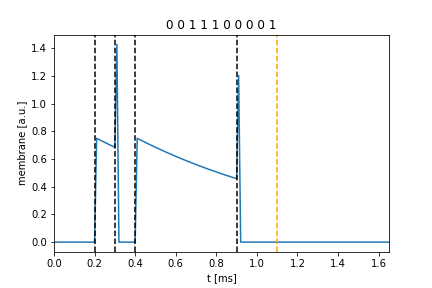

<IPython.core.display.Javascript object>


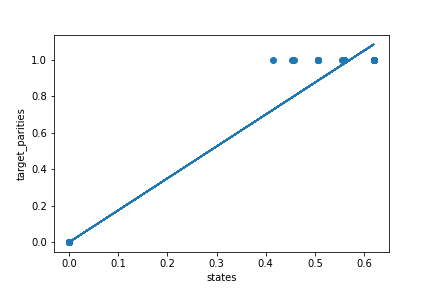

mismatched training examples: 0/40 [0.0%]
mismatched test examples: 0/10 [0.0%]


In [18]:
# membrane time constant in ms
# simulation time in ms
sim_time = 1000.
                        
# number of bits
n_bit = 10

# time delay between bits in ms
input_delay_per_bit = 0.1

# membrane time constant in ms
membrane_time_constant = 1.

# refractory period in ms
refractory_period = 0.05

# heuristic stimulation interval and readout delay
# need to be tuned when, e.g., membrane time constants is changed from the default
stim_interval = n_bit * input_delay_per_bit * membrane_time_constant * 20
readout_delay = (n_bit + 1) * input_delay_per_bit

print(f"{stim_interval=}")
print(f"{readout_delay=}")

sim_fig, ana_fig = main(sim_time, n_bit, membrane_time_constant, refractory_period,
                        input_delay_per_bit, stim_interval, readout_delay)